### Problem Predator
To make life a little more interesting on Daisyworld, add a population of rabbits that feed upon the daisies. The
rabbit birth rate will be proportional to the area covered by the daisies while, conversely, the daisy *death rate* will be proportional to the rabbit population.

Add another equation to the Daisyworld model which governs the rabbit population and make the appropriate modifications to the existing daisy equations. Modify the set of equations and solve it with the Runge-Kutta method with adaptive timesteps. Use it to look for steady states and to determine their dependence on the initial conditions and model parameters.

Hand in notebook cells that:

1.  Show your modified Daisyworld equations and your new integrator class.

2.  At least one set of parameter values and initial conditions that leads to the steady state and a plot of the timeseries for the daisies and rabbits.

3.  A discussion of the steady state’s dependence on these values, i.e. what happens when they are altered. Include a few plots for illustration.

4.  Does adding this feedback extend the range of habital L values  for which non-zero populations exist?


First, I need to write the equations for the Rabbits population. Therefore, I need to change the Integrator Class:

In [152]:
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
#
from numlabs.lab5.lab5_funs import Integrator


class Integ54(Integrator):
    def set_yinit(self):
        #        
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #        
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.irabbits])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        ###################################################
        # NEW EQUATIONS
        bare = 1.0 - y[0] - y[1]
        bare_r = 1 - y[2]
        #
        i_rabbits = 0.6 * ((y[0] + y[1]))
        #
        grazing = 0.5 * y[2]

        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi) - y[0]*grazing
        f[1] = y[1] * (beta_b * bare - user.chi) - y[1]*grazing
        f[2] = y[2] * (i_rabbits * bare_r - user.chirabbits)
        return f

In [153]:
import pandas as pd
theSolver = Integ54('predators.yaml')
timevals, yVals, errorList = theSolver.timeloop5Err()

yvals = pd.DataFrame(yVals, columns=['white', 'black', 'rabbits'])

Text(0.5, 1.0, 'Fractional Coverage in Daisy World with Adaptive Timestep')

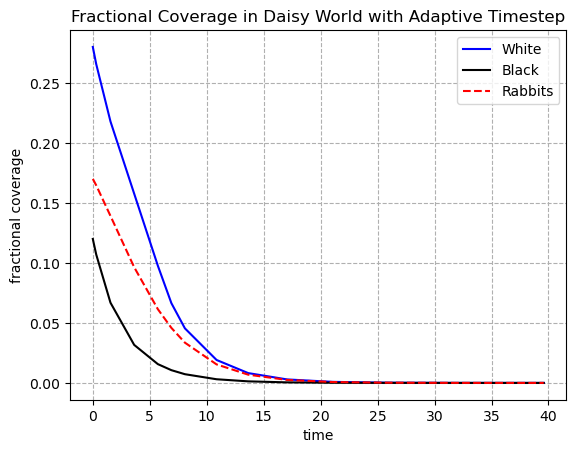

In [154]:
plt.plot(timevals, yvals['white'], 'b', label='White')
plt.plot(timevals, yvals['black'], 'k',label='Black')
plt.plot(timevals, yvals['rabbits'], '--r', label='Rabbits')
plt.xlabel('time')
plt.ylabel('fractional coverage')
plt.legend()
plt.grid(linestyle='--')
plt.title('Fractional Coverage in Daisy World with Adaptive Timestep')